In [70]:
from jupyterthemes import jtplot
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from datetime import datetime
from time import time
import seaborn as sns
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score
jtplot.style()

In [2]:
parcels_taxvals_merged_url = 'https://media.githubusercontent.com/media/rohanskalyani/sfpermittimes/main/Data/parcels_taxvals_merged.csv?raw=true'
SFDBIData_url = 'https://media.githubusercontent.com/media/rohanskalyani/sfpermittimes/main/Data/SFDBI_Permits.csv?raw=true'

parcels_taxvals_merged = pd.read_csv(parcels_taxvals_merged_url, index_col = 0)
SFDBIPermit = pd.read_csv(SFDBIData_url)

In [3]:
parcels_taxvals_merged.head()

,project_id_drop,from_address_num,date_map_alt,odd_even,zoning_code,zoning_district,pw_recorded_map,mapblklot,date_map_add,to_address_num,...,blklot,in_asr_secured_roll,date_rec_add,lot_num,active,geometry,Parcel Number,Number of Rooms,Property Area,Total Taxable Value
0,NaN,1301.0,NaN,O,C-2,COMMUNITY BUSINESS,True,0024002,1998-07-01,1301.0,...,0024002,True,NaN,002,True,MULTIPOLYGON (((-122.4189408105767 37.80599835...,0024002,10.0,2770.0,843421.0
1,NaN,710.0,NaN,E,RH-3,"RESIDENTIAL- HOUSE, THREE FAMILY",True,0024005,1998-07-01,710.0,...,0024005,True,NaN,005,True,MULTIPOLYGON (((-122.41917559180574 37.8059683...,0024005,13.0,2812.0,1832895.0
2,NaN,712.0,NaN,E,RH-3,"RESIDENTIAL- HOUSE, THREE FAMILY",True,0024006,1998-07-01,714.0,...,0024006,True,NaN,006,True,MULTIPOLYGON (((-122.41925385141641 37.8059584...,0024006,12.0,3402.0,443974.0
3,NaN,736.0,NaN,E,RH-3,"RESIDENTIAL- HOUSE, THREE FAMILY",True,0024007,1998-07-01,740.0,...,0024007,True,NaN,007,True,MULTIPOLYGON (((-122.41933074453019 37.8059485...,0024007,10.0,2437.0,168992.0
4,NaN,760.0,NaN,E,RH-3,"RESIDENTIAL- HOUSE, THREE FAMILY",True,0024009,1998-07-01,760.0,...,0024009,True,NaN,009,True,MULTIPOLYGON (((-122.41964401475822 37.8059086...,0024009,0.0,7498.0,1382702.0


In [3]:
Master_merge = parcels_taxvals_merged.merge(SFDBIPermit, how='inner', left_on='mapblklot', right_on='Parcel Number')

In [112]:
Master_merge_geo = gpd.GeoDataFrame(data = Master_merge, crs= 'EPSG:4326', geometry= 'geometry_y')

In [241]:
Regression_Table = census_merge[['wait_time','Number of Rooms','Property Area',
                                 'Total Taxable Value','revised_cost','site_permit','estimated_cost', 
                                 'proposed_units','number_of_proposed_stories','year', 'Median household income']]

In [242]:
Regression_Table.describe()

,wait_time,Number of Rooms,Property Area,Total Taxable Value,revised_cost,estimated_cost,proposed_units,number_of_proposed_stories,year,Median household income
count,693.000000,693.000000,693.000000,6.930000e+02,6.930000e+02,6.930000e+02,693.000000,693.000000,693.000000,693.000000
mean,494.493506,7.748911,5595.704858,4.726910e+06,1.650570e+07,1.554232e+07,54.584416,4.662338,2016.121212,104364.454545
std,361.062996,34.406479,18750.697888,1.414641e+07,3.744790e+07,3.618780e+07,81.742673,4.676683,2.102784,57169.721594
min,35.000000,0.000000,0.000000,0.000000e+00,1.000000e+03,1.000000e+00,0.000000,0.000000,2013.000000,250.000000
25%,303.000000,0.000000,817.000000,4.316960e+05,5.500000e+05,4.200000e+05,1.000000,3.000000,2014.000000,60104.000000
50%,340.000000,3.000000,1309.000000,7.974040e+05,1.600000e+06,1.500000e+06,3.000000,4.000000,2016.000000,82321.000000
75%,631.000000,6.000000,1909.000000,2.155378e+06,2.600000e+07,2.600000e+07,136.000000,5.000000,2017.000000,154345.000000
max,2212.000000,408.000000,169167.200000,1.409837e+08,5.200000e+08,5.200000e+08,550.000000,60.000000,2021.000000,241167.000000


In [118]:
Regression_Table.corr()

,wait_time,Number of Rooms,Property Area,Total Taxable Value,revised_cost,site_permit,estimated_cost,proposed_units,number_of_proposed_stories,year,Median household income
wait_time,1.000000,-0.004827,0.038674,0.024734,-0.025040,0.273760,-0.031940,-0.140666,0.037689,0.524887,0.255631
Number of Rooms,-0.004827,1.000000,0.212893,0.119606,-0.010365,-0.096186,-0.010769,-0.062615,-0.039883,0.041012,0.068205
Property Area,0.038674,0.212893,1.000000,0.602026,0.356550,0.009783,0.336815,0.234192,0.276528,0.042236,0.140918
Total Taxable Value,0.024734,0.119606,0.602026,1.000000,0.494055,0.080745,0.449177,0.428986,0.478951,-0.030125,0.269686
revised_cost,-0.025040,-0.010365,0.356550,0.494055,1.000000,0.158859,0.994315,0.730844,0.872696,0.006344,0.074499
site_permit,0.273760,-0.096186,0.009783,0.080745,0.158859,1.000000,0.156831,0.241676,0.180844,0.052932,0.194987
estimated_cost,-0.031940,-0.010769,0.336815,0.449177,0.994315,0.156831,1.000000,0.707497,0.849823,0.001133,0.056317
proposed_units,-0.140666,-0.062615,0.234192,0.428986,0.730844,0.241676,0.707497,1.000000,0.628321,-0.225549,-0.101500
number_of_proposed_stories,0.037689,-0.039883,0.276528,0.478951,0.872696,0.180844,0.849823,0.628321,1.000000,0.050603,0.126899
year,0.524887,0.041012,0.042236,-0.030125,0.006344,0.052932,0.001133,-0.225549,0.050603,1.000000,0.304188


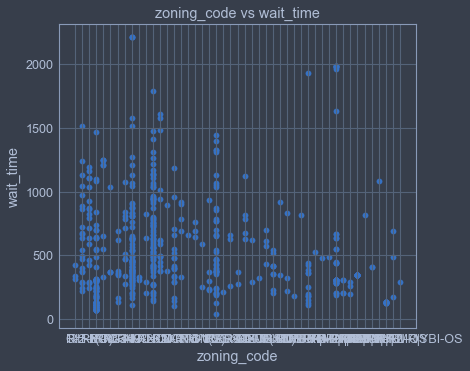

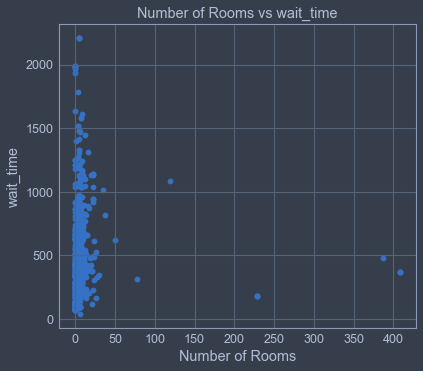

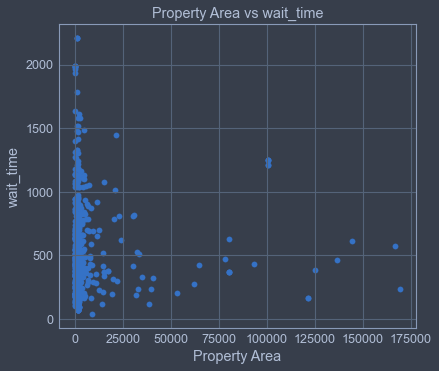

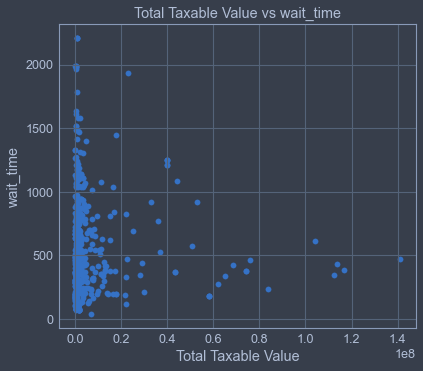

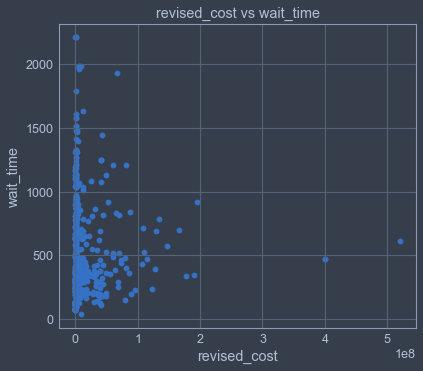

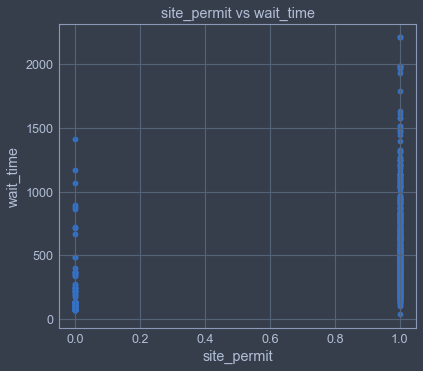

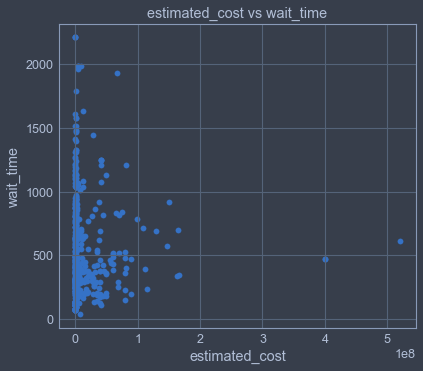

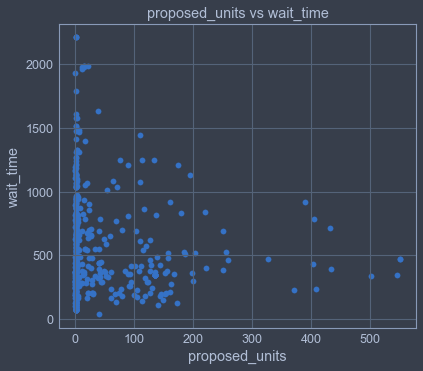

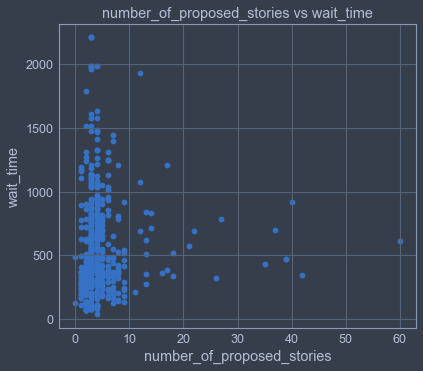

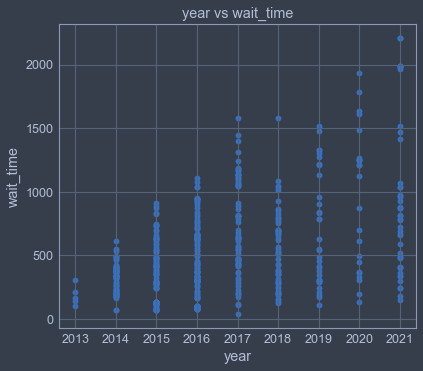

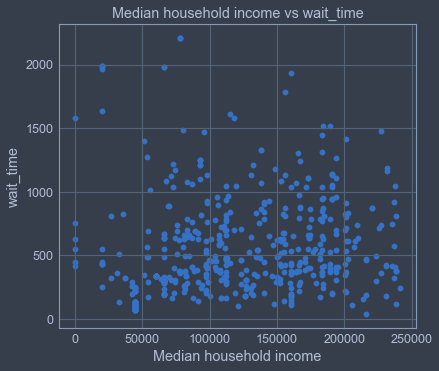

In [119]:
regressors = list(Regression_Table.columns)[1:]

for reg in regressors:

    figure = plt.figure
    ax = plt.gca()
    ax.scatter(Regression_Table[reg],Regression_Table['wait_time'])
    ax.set_xlabel(reg)
    ax.set_ylabel('wait_time')
    ax.set_title("{} vs {}".format(reg,'wait_time'))
    plt.show()

<AxesSubplot:xlabel='zoning_code', ylabel='wait_time'>

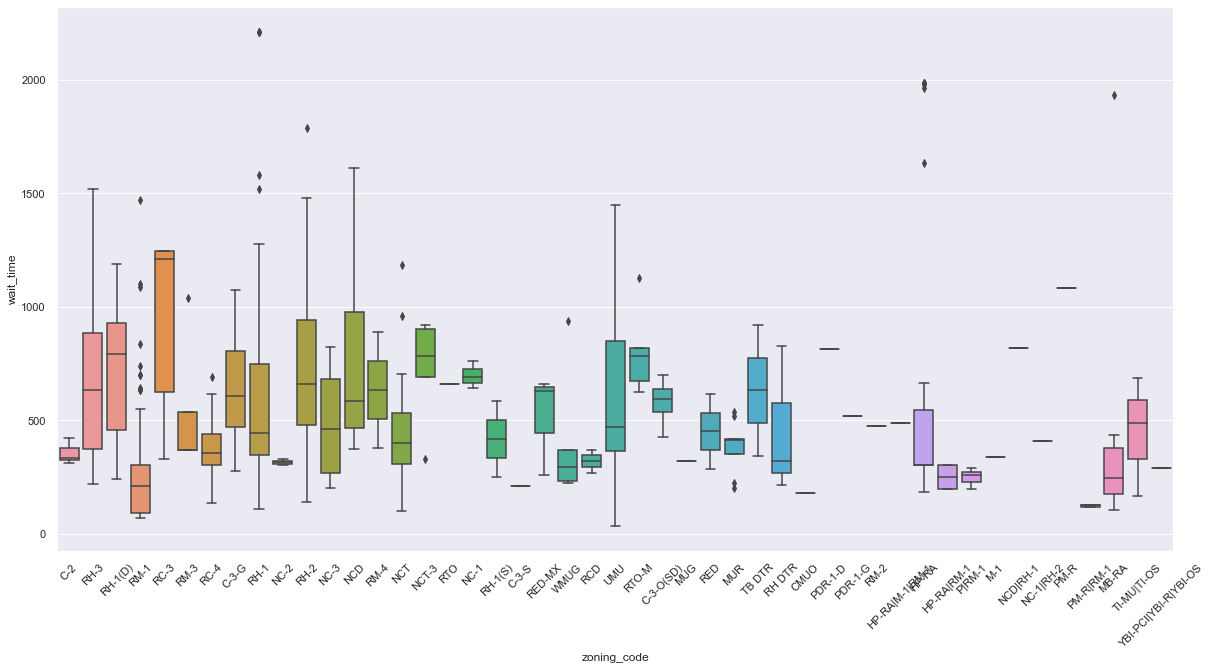

In [11]:
sns.set(rc = {'figure.figsize':(20,10)})
plt.xticks(rotation=45)
sns.boxplot(y='wait_time',x='zoning_code',data=Regression_Table)

<AxesSubplot:xlabel='zoning_code', ylabel='wait_time'>

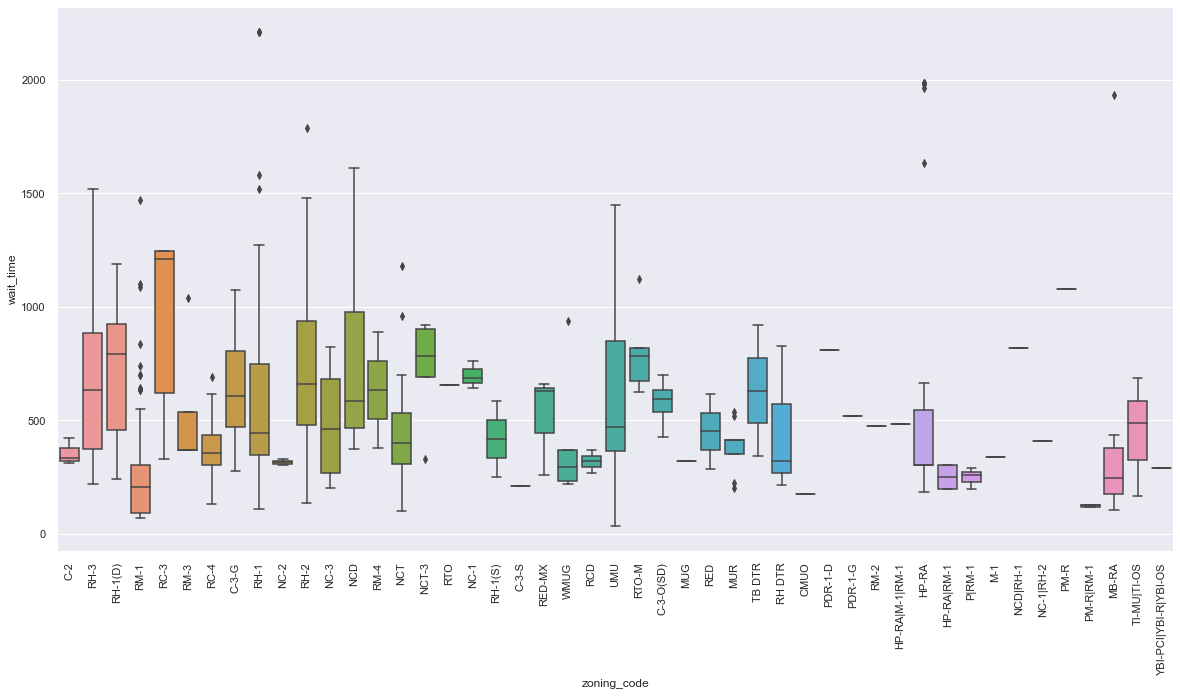

In [14]:
sns.set(rc = {'figure.figsize':(20,10)})
plt.xticks(rotation=90)
sns.boxplot(y='wait_time',x='zoning_code',data=Regression_Table)

In [120]:
Regression_Table_wDummies = pd.get_dummies(data=Regression_Table, drop_first=True)
Regression_Table_wDummies.isna().sum()

wait_time                           0
Number of Rooms                     0
Property Area                       0
Total Taxable Value                 0
revised_cost                        0
site_permit                         0
estimated_cost                      0
proposed_units                      0
number_of_proposed_stories          0
year                                0
Median household income             0
zoning_code_C-3-G                   0
zoning_code_C-3-O(SD)               0
zoning_code_C-3-S                   0
zoning_code_CMUO                    0
zoning_code_HP-RA                   0
zoning_code_HP-RA|M-1|RM-1          0
zoning_code_HP-RA|RM-1              0
zoning_code_M-1                     0
zoning_code_MB-RA                   0
zoning_code_MUG                     0
zoning_code_MUR                     0
zoning_code_NC-1                    0
zoning_code_NC-1|RH-2               0
zoning_code_NC-2                    0
zoning_code_NC-3                    0
zoning_code_

In [121]:
Regression_Table_wDummies.corr().sort_values(by='wait_time', ascending =False)

,wait_time,Number of Rooms,Property Area,Total Taxable Value,revised_cost,site_permit,estimated_cost,proposed_units,number_of_proposed_stories,year,...,zoning_code_RM-2,zoning_code_RM-3,zoning_code_RM-4,zoning_code_RTO,zoning_code_RTO-M,zoning_code_TB DTR,zoning_code_TI-MU|TI-OS,zoning_code_UMU,zoning_code_WMUG,zoning_code_YBI-PCI|YBI-R|YBI-OS
wait_time,1.000000,-0.004827,0.038674,0.024734,-0.025040,0.273760,-0.031940,-0.140666,0.037689,0.524887,...,-0.001948,0.008713,0.020876,0.017227,0.073366,0.020429,-0.008558,0.089400,-0.019728,-0.021546
year,0.524887,0.041012,0.042236,-0.030125,0.006344,0.052932,0.001133,-0.225549,0.050603,1.000000,...,0.088263,0.040931,0.009698,-0.002193,0.068109,-0.003103,0.132177,0.040839,0.019425,0.052081
site_permit,0.273760,-0.096186,0.009783,0.080745,0.158859,1.000000,0.156831,0.241676,0.180844,0.052932,...,0.014592,-0.141557,-0.059750,0.014592,0.032724,0.020652,0.025311,0.077979,0.032724,0.014592
Median household income,0.255631,0.068205,0.140918,0.269686,0.074499,0.194987,0.056317,-0.101500,0.126899,0.304188,...,0.005250,0.022009,-0.029594,0.001916,-0.012946,0.107469,-0.057698,0.300574,-0.002071,-0.033264
zoning_code_RH-2,0.208991,-0.007012,-0.080440,-0.086139,-0.147453,0.051905,-0.145381,-0.228367,-0.111995,0.127001,...,-0.013342,-0.026741,-0.018882,-0.013342,-0.029920,-0.018882,-0.023142,-0.088010,-0.029920,-0.013342
zoning_code_RC-3,0.139804,-0.018070,0.333097,0.168344,0.064781,0.041484,0.059195,0.036933,0.071401,0.135199,...,-0.004108,-0.008234,-0.005814,-0.004108,-0.009213,-0.005814,-0.007126,-0.027100,-0.009213,-0.004108
zoning_code_RH-1(D),0.115944,-0.004977,-0.027435,-0.035359,-0.067068,-0.018665,-0.066096,-0.107457,-0.071676,0.063977,...,-0.006208,-0.012442,-0.008785,-0.006208,-0.013921,-0.008785,-0.010768,-0.040950,-0.013921,-0.006208
zoning_code_NCD,0.113056,0.010563,-0.012250,-0.027283,-0.051499,0.057096,-0.055288,-0.079365,-0.021081,0.118835,...,-0.005654,-0.011333,-0.008002,-0.005654,-0.012680,-0.008002,-0.009808,-0.037299,-0.012680,-0.005654
zoning_code_RH-1,0.107607,-0.025669,-0.080627,-0.088625,-0.154748,0.061894,-0.152392,-0.242360,-0.158789,0.154268,...,-0.014022,-0.028106,-0.019845,-0.014022,-0.031446,-0.019845,-0.024323,-0.092500,-0.031446,-0.014022
zoning_code_UMU,0.089400,-0.000268,0.156165,0.301801,0.072584,0.077979,0.061731,0.118458,0.039059,0.040839,...,-0.009533,-0.019107,-0.013491,-0.009533,-0.021378,-0.013491,-0.016535,1.000000,-0.021378,-0.009533


In [64]:
sf_census_data = gpd.read_file('https://raw.githubusercontent.com/rohanskalyani/sfpermittimes/main/Data/Block%20Group%20Median%20Household%20Income.geojson'); sf_census_data.head()

,Shape__Area,Shape__Length,Geographic Area Name,Median household income,geometry
0,0.000123,0.053583,"Block Group 1, Census Tract 101, San Francisco...",103466.0,"POLYGON ((-122.42108 37.81289, -122.42018 37.8..."
1,0.000022,0.028353,"Block Group 2, Census Tract 101, San Francisco...",32087.0,"POLYGON ((-122.41689 37.80521, -122.41524 37.8..."
2,0.000057,0.038006,"Block Group 1, Census Tract 102, San Francisco...",166630.0,"POLYGON ((-122.42663 37.80974, -122.42653 37.8..."
3,0.000013,0.019144,"Block Group 2, Census Tract 102, San Francisco...",144358.0,"POLYGON ((-122.42484 37.80227, -122.42465 37.8..."
4,0.000013,0.019144,"Block Group 3, Census Tract 102, San Francisco...",152692.0,"POLYGON ((-122.42661 37.80815, -122.42651 37.8..."


In [107]:
#census_merge.dtypes
census_merge = Master_merge_geo.sjoin(sf_census_data, how = 'inner'); census_merge.head()

,project_id_drop,from_address_num,date_map_alt,odd_even,zoning_code,zoning_district,pw_recorded_map,mapblklot,date_map_add,to_address_num,...,street_number,geometry_y,wait_time,year,Parcel Number_y,index_right,Shape__Area,Shape__Length,Geographic Area Name,Median household income
0,NaN,3000.0,NaN,E,C-2,COMMUNITY BUSINESS,True,0025024,1998-07-01,3012.0,...,898,POINT (-122.42182 37.80575),422.0,2016,0025024,2,0.000057,0.038006,"Block Group 1, Census Tract 102, San Francisco...",166630.0
2,NaN,737.0,NaN,O,RH-3,"RESIDENTIAL- HOUSE, THREE FAMILY",True,0045017,1998-07-01,737.0,...,737,POINT (-122.41916 37.80463),219.0,2014,0045017,2,0.000057,0.038006,"Block Group 1, Census Tract 102, San Francisco...",166630.0
3,NaN,819.0,NaN,O,RH-1(D),"RESIDENTIAL- HOUSE, ONE FAMILY- DETACHED",True,0048018,1998-07-01,819.0,...,819,POINT (-122.41906 37.80373),792.0,2018,0048018,2,0.000057,0.038006,"Block Group 1, Census Tract 102, San Francisco...",166630.0
1,NaN,1255.0,NaN,O,C-2,COMMUNITY BUSINESS,True,0028014,1998-07-01,1275.0,...,1275,POINT (-122.41830 37.80561),312.0,2014,0028014,5,0.000013,0.017261,"Block Group 1, Census Tract 103, San Francisco...",152167.0
4,NaN,844.0,NaN,E,RM-1,"RESIDENTIAL- MIXED, LOW DENSITY",True,0066006,1998-07-01,844.0,...,844,POINT (-122.41547 37.80281),285.0,2015,0066006,5,0.000013,0.017261,"Block Group 1, Census Tract 103, San Francisco...",152167.0


In [164]:
census_merge.to_file('C:/Users/Rohan/Documents/NYU/PUI/SFPermitTimes/Data/census_merged.geojson', driver = 'GeoJSON')

In [122]:
X = Regression_Table_wDummies.iloc[:,1:].values
y = Regression_Table_wDummies['wait_time'].values
feature_names = np.array(Regression_Table_wDummies.iloc[:,1:].columns)

In [131]:
lr_estimator = LinearRegression()
lr_selector = SequentialFeatureSelector(lr_estimator, n_features_to_select=5, direction='forward').fit(X, y)

In [132]:
lr_selector.get_feature_names_out(feature_names)

array(['site_permit', 'proposed_units', 'year', 'zoning_code_MUR',
       'zoning_code_RM-1'], dtype=object)

In [140]:
fw_model_1 = smf.ols(formula = 'wait_time ~ site_permit + proposed_units + year + Q("zoning_code_MUR") + Q("zoning_code_RM-1")', 
                     data = Regression_Table_wDummies).fit()
print(fw_model_1.summary())

                            OLS Regression Results                            
Dep. Variable:              wait_time   R-squared:                       0.371
Model:                            OLS   Adj. R-squared:                  0.367
Method:                 Least Squares   F-statistic:                     81.10
Date:                Tue, 07 Dec 2021   Prob (F-statistic):           6.91e-67
Time:                        00:30:16   Log-Likelihood:                -4903.2
No. Observations:                 693   AIC:                             9818.
Df Residuals:                     687   BIC:                             9846.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept             -1.655e+

In [126]:
lasso_estimator = LassoCV().fit(X,y)
lasso_selector = SequentialFeatureSelector(lasso_estimator, n_features_to_select=5, direction='forward').fit(X, y)
lasso_selector.get_feature_names_out(feature_names)

C:\Users\Rohan\anaconda3\envs\geo_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.975e+04, tolerance: 9.021e+03
  model = cd_fast.enet_coordinate_descent(


array(['site_permit', 'year', 'zoning_code_MB-RA', 'zoning_code_NCT',
       'zoning_code_RH-3'], dtype=object)

In [63]:
lasso_model = smf.ols(formula = 'wait_time ~ site_permit+year+Q("zoning_code_MB-RA")+Q("zoning_code_RH-3")+Q("zoning_code_TI-MU|TI-OS")', data = Regression_Table_wDummies).fit()
print(lasso_model.summary())

                            OLS Regression Results                            
Dep. Variable:              wait_time   R-squared:                       0.354
Model:                            OLS   Adj. R-squared:                  0.349
Method:                 Least Squares   F-statistic:                     75.11
Date:                Mon, 06 Dec 2021   Prob (F-statistic):           9.69e-63
Time:                        23:21:16   Log-Likelihood:                -4897.8
No. Observations:                 691   AIC:                             9808.
Df Residuals:                     685   BIC:                             9835.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [130]:
model_with_sel_vars = smf.ols(formula = 'wait_time~year+site_permit+Q("Median household income")+proposed_units+Q("zoning_code_RH-2")',
                              data = Regression_Table_wDummies).fit()
model_with_sel_vars.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              wait_time   R-squared:                       0.358
Model:                            OLS   Adj. R-squared:                  0.353
Method:                 Least Squares   F-statistic:                     76.58
Date:                Tue, 07 Dec 2021   Prob (F-statistic):           8.61e-64
Time:                        00:18:51   Log-Likelihood:                -4910.5
No. Observations:                 693   AIC:                             9833.
Df Residuals:                     687   BIC:                             9860.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                    -1.644e+05   1.14e+04    -14.470      0.000   -1.87e+05   -1.42e+05
site_permit[T.True]            274.8124     34.986      7.855      0.000     206.121     343.504
year                            81.6634      5.638     14.484      0.000      70.593      92.734
Q("Median household income")     0.0001      0.000      0.604      0.546      -0.000       0.001
proposed_units                  -0.2954      0.147     -2.003      0.046      -0.585      -0.006
Q("zoning_code_RH-2")          131.6036     37.865      3.476      0.001      57.258     205.949
==============================================================================
Omnibus:                      154.025   Durbin-Watson:                   1.514
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              445.814
Skew:                           1.086   Prob(JB):                     1.56e-97
Kurtosis:                       6.274   Cond. No.                     1.23e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.23e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [133]:
lr_selector_back = SequentialFeatureSelector(lr_estimator, n_features_to_select=5, direction='backward').fit(X, y)
lr_selector_back.get_feature_names_out(feature_names)

array(['site_permit', 'proposed_units', 'year', 'zoning_code_M-1',
       'zoning_code_RM-1'], dtype=object)

In [146]:
model_2 = smf.ols(formula = 'wait_time~Q("Median household income")',
                              data = Regression_Table_wDummies).fit()
print(model_2.summary())

                            OLS Regression Results                            
Dep. Variable:              wait_time   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     48.31
Date:                Tue, 07 Dec 2021   Prob (F-statistic):           8.42e-12
Time:                        00:33:41   Log-Likelihood:                -5040.5
No. Observations:                 693   AIC:                         1.009e+04
Df Residuals:                     691   BIC:                         1.009e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [147]:
Regression_Table_wDummies.columns

Index(['wait_time', 'Number of Rooms', 'Property Area', 'Total Taxable Value',
       'revised_cost', 'site_permit', 'estimated_cost', 'proposed_units',
       'number_of_proposed_stories', 'year', 'Median household income',
       'zoning_code_C-3-G', 'zoning_code_C-3-O(SD)', 'zoning_code_C-3-S',
       'zoning_code_CMUO', 'zoning_code_HP-RA', 'zoning_code_HP-RA|M-1|RM-1',
       'zoning_code_HP-RA|RM-1', 'zoning_code_M-1', 'zoning_code_MB-RA',
       'zoning_code_MUG', 'zoning_code_MUR', 'zoning_code_NC-1',
       'zoning_code_NC-1|RH-2', 'zoning_code_NC-2', 'zoning_code_NC-3',
       'zoning_code_NCD', 'zoning_code_NCD|RH-1', 'zoning_code_NCT',
       'zoning_code_NCT-3', 'zoning_code_PDR-1-D', 'zoning_code_PDR-1-G',
       'zoning_code_PM-R', 'zoning_code_PM-R|RM-1', 'zoning_code_P|RM-1',
       'zoning_code_RC-3', 'zoning_code_RC-4', 'zoning_code_RCD',
       'zoning_code_RED', 'zoning_code_RED-MX', 'zoning_code_RH DTR',
       'zoning_code_RH-1', 'zoning_code_RH-1(D)', 'zoning_co

In [154]:
outlierIndex = (Regression_Table_wDummies['Number of Rooms'] < 100) & \
(Regression_Table_wDummies['Property Area'] < 50000) & \
(Regression_Table_wDummies['Total Taxable Value'] < 0.6e8) & \
(Regression_Table_wDummies['revised_cost'] < 2e8) & \
(Regression_Table_wDummies['estimated_cost'] < 2e8) & \
(Regression_Table_wDummies['proposed_units'] < 300) & \
(Regression_Table_wDummies['number_of_proposed_stories'] < 30)

Regression_Table_wDummies_no_outliers = Regression_Table_wDummies.loc[outlierIndex]
(Regression_Table_wDummies.shape, Regression_Table_wDummies_no_outliers.shape)

((693, 57), (656, 57))

In [208]:
Regression_Table_wDummies_no_outliers.columns

Index(['wait_time', 'Number of Rooms', 'Property Area', 'Total Taxable Value',
       'revised_cost', 'site_permit', 'estimated_cost', 'proposed_units',
       'number_of_proposed_stories', 'year', 'Median household income',
       'zoning_code_C-3-G', 'zoning_code_C-3-O(SD)', 'zoning_code_C-3-S',
       'zoning_code_CMUO', 'zoning_code_HP-RA', 'zoning_code_HP-RA|M-1|RM-1',
       'zoning_code_HP-RA|RM-1', 'zoning_code_M-1', 'zoning_code_MB-RA',
       'zoning_code_MUG', 'zoning_code_MUR', 'zoning_code_NC-1',
       'zoning_code_NC-1|RH-2', 'zoning_code_NC-2', 'zoning_code_NC-3',
       'zoning_code_NCD', 'zoning_code_NCD|RH-1', 'zoning_code_NCT',
       'zoning_code_NCT-3', 'zoning_code_PDR-1-D', 'zoning_code_PDR-1-G',
       'zoning_code_PM-R', 'zoning_code_PM-R|RM-1', 'zoning_code_P|RM-1',
       'zoning_code_RC-3', 'zoning_code_RC-4', 'zoning_code_RCD',
       'zoning_code_RED', 'zoning_code_RED-MX', 'zoning_code_RH DTR',
       'zoning_code_RH-1', 'zoning_code_RH-1(D)', 'zoning_co

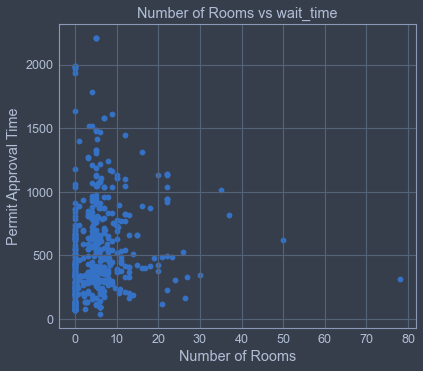

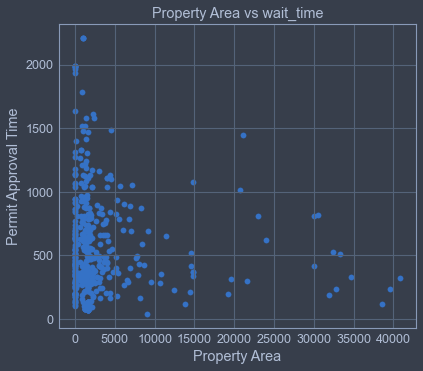

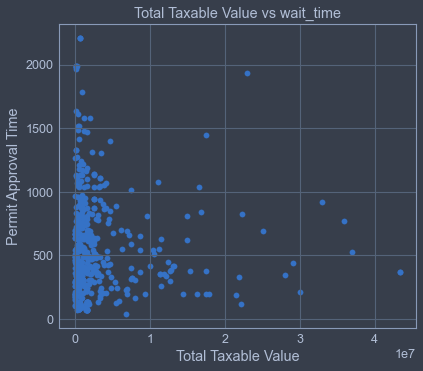

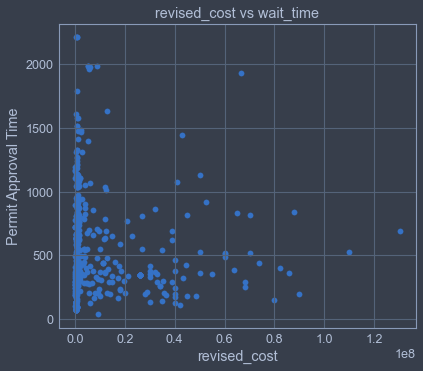

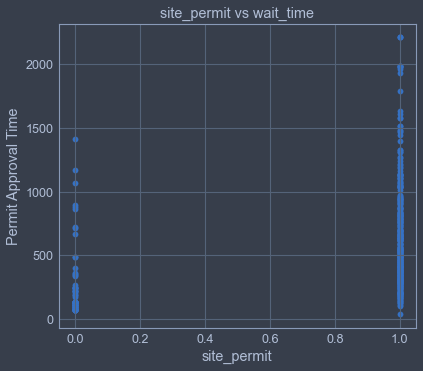

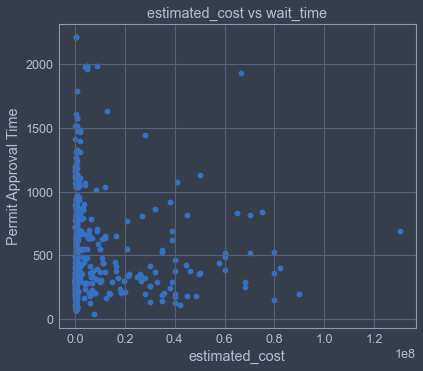

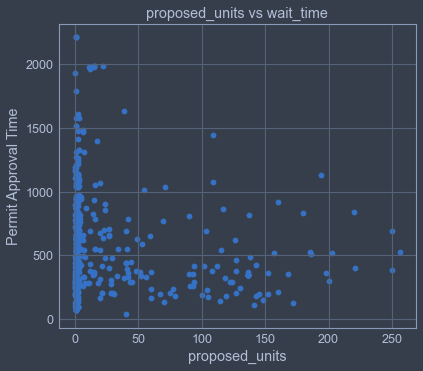

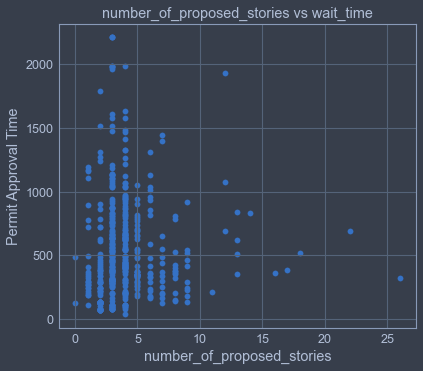

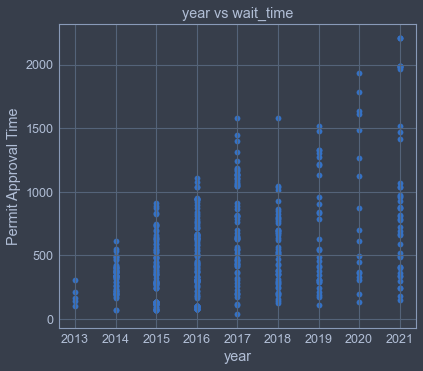

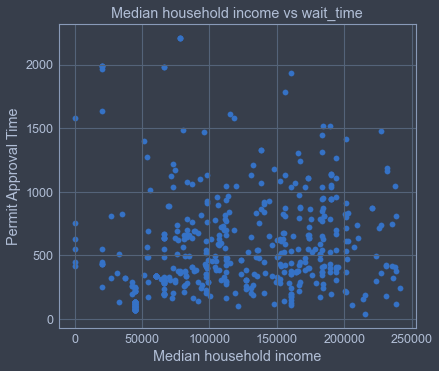

In [207]:
for reg in regressors[1:]:

    figure = plt.figure
    ax = plt.gca()
    ax.scatter(Regression_Table_wDummies_no_outliers[reg],Regression_Table_wDummies_no_outliers['wait_time'])
    ax.set_xlabel(reg)
    ax.set_ylabel('Permit Approval Time (days)')
    ax.set_title("{} vs {}".format('Approval Time',reg))
    plt.show()

In [239]:
((Regression_Table_wDummies_no_outliers == 0).sum()/len(Regression_Table_wDummies_no_outliers)).sort_values(ascending = False)

zoning_code_RM-2                    1.000000
zoning_code_PM-R                    1.000000
zoning_code_TB DTR                  1.000000
zoning_code_C-3-O(SD)               1.000000
zoning_code_YBI-PCI|YBI-R|YBI-OS    0.998476
zoning_code_MUG                     0.998476
zoning_code_CMUO                    0.998476
zoning_code_C-3-S                   0.998476
zoning_code_RM-3                    0.998476
zoning_code_NCD|RH-1                0.998476
zoning_code_RTO                     0.998476
zoning_code_PDR-1-D                 0.998476
zoning_code_PDR-1-G                 0.998476
zoning_code_HP-RA|M-1|RM-1          0.998476
zoning_code_RED                     0.996951
zoning_code_NC-2                    0.996951
zoning_code_NC-1|RH-2               0.996951
zoning_code_RCD                     0.996951
zoning_code_RM-4                    0.996951
zoning_code_RH-1(S)                 0.996951
zoning_code_RH DTR                  0.995427
zoning_code_RC-3                    0.995427
zoning_cod

In [160]:
X_no_outliers = Regression_Table_wDummies_no_outliers.iloc[:,1:].values
y_no_outliers = Regression_Table_wDummies_no_outliers['wait_time'].values

In [161]:
lasso_estimator_no_outliers = LassoCV().fit(X_no_outliers,y_no_outliers)
lasso_selector_no_outliers = SequentialFeatureSelector(lasso_estimator_no_outliers, 
                                                       n_features_to_select=5, 
                                                       direction='forward').fit(X_no_outliers, y_no_outliers)
lasso_selector_no_outliers.get_feature_names_out(feature_names)

array(['site_permit', 'number_of_proposed_stories', 'year',
       'zoning_code_MUR', 'zoning_code_RH-1(D)'], dtype=object)

In [162]:
lasso_model_no_outliers = smf.ols(formula = 'wait_time ~ site_permit+year+number_of_proposed_stories+Q("zoning_code_MUR")+Q("zoning_code_RH-1(D)")', 
                                  data = Regression_Table_wDummies_no_outliers).fit()
print(lasso_model_no_outliers.summary())

                            OLS Regression Results                            
Dep. Variable:              wait_time   R-squared:                       0.344
Model:                            OLS   Adj. R-squared:                  0.339
Method:                 Least Squares   F-statistic:                     68.07
Date:                Tue, 07 Dec 2021   Prob (F-statistic):           3.31e-57
Time:                        17:01:38   Log-Likelihood:                -4657.0
No. Observations:                 656   AIC:                             9326.
Df Residuals:                     650   BIC:                             9353.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

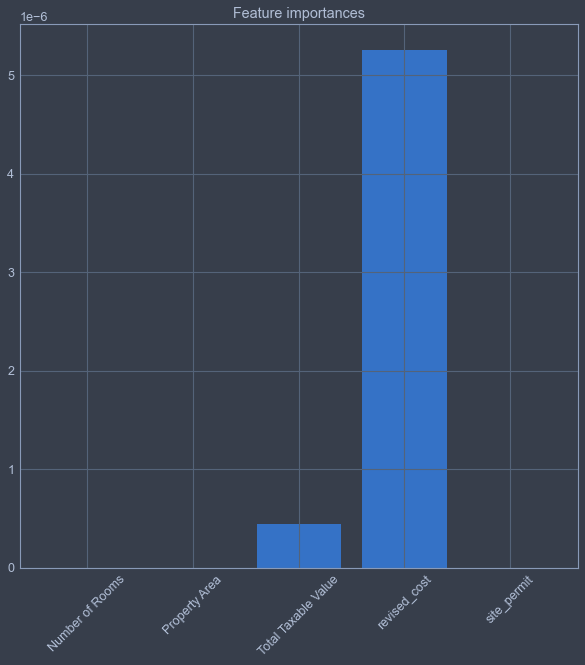

In [205]:
importance = np.abs(lasso_estimator_no_outliers.coef_)
fig, ax = plt.subplots(figsize = (10,10))
ax.bar(x = feature_names[:5], height = importance[:5])
plt.title('Feature importances')
plt.xticks(rotation=45)
plt.show()

In [172]:
model_via_importance = smf.ols(formula = 'wait_time~Q("Median household income")+estimated_cost+revised_cost',
                              data = Regression_Table_wDummies_no_outliers).fit()
print(model_via_importance.summary())

                            OLS Regression Results                            
Dep. Variable:              wait_time   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     20.46
Date:                Tue, 07 Dec 2021   Prob (F-statistic):           1.11e-12
Time:                        17:38:23   Log-Likelihood:                -4765.6
No. Observations:                 656   AIC:                             9539.
Df Residuals:                     652   BIC:                             9557.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [185]:
lasso_selector_no_outliers_bck = SequentialFeatureSelector(lasso_estimator_no_outliers, 
                                                       n_features_to_select=5, 
                                                       direction='backward').fit(X_no_outliers, y_no_outliers)
lasso_selector_no_outliers.get_feature_names_out(feature_names)

array(['site_permit', 'number_of_proposed_stories', 'year',
       'zoning_code_MUR', 'zoning_code_RH-1(D)'], dtype=object)

In [186]:
lasso_model_no_outliers_bck = smf.ols(formula = 'wait_time ~ site_permit+year+number_of_proposed_stories+Q("zoning_code_MUR")+Q("zoning_code_RH-1(D)")', 
                                  data = Regression_Table_wDummies_no_outliers).fit()
print(lasso_model_no_outliers_bck.

                            OLS Regression Results                            
Dep. Variable:              wait_time   R-squared:                       0.344
Model:                            OLS   Adj. R-squared:                  0.339
Method:                 Least Squares   F-statistic:                     68.07
Date:                Tue, 07 Dec 2021   Prob (F-statistic):           3.31e-57
Time:                        18:09:16   Log-Likelihood:                -4657.0
No. Observations:                 656   AIC:                             9326.
Df Residuals:                     650   BIC:                             9353.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [192]:
#test for best number of features
lasso_estimator_no_outliers = LassoCV().fit(X_no_outliers,y_no_outliers)
sel_features = []
for num in np.arange(1,6):
    lasso_selector = SequentialFeatureSelector(lasso_estimator_no_outliers, 
                                                       n_features_to_select=num, 
                                                       direction='forward').fit(X_no_outliers, y_no_outliers)
    sel_features.append(lasso_selector.get_feature_names_out(feature_names))

sel_features


[array(['year'], dtype=object),
 array(['site_permit', 'year'], dtype=object),
 array(['site_permit', 'year', 'zoning_code_MUR'], dtype=object),
 array(['site_permit', 'number_of_proposed_stories', 'year',
        'zoning_code_MUR'], dtype=object),
 array(['site_permit', 'number_of_proposed_stories', 'year',
        'zoning_code_MUR', 'zoning_code_RH-1(D)'], dtype=object)]

In [197]:
'wait_time ~ '+ '+'.join(sel_features[3])

'wait_time ~ site_permit+number_of_proposed_stories+year+zoning_code_MUR'

In [198]:
lasso_model_no_outliers_bck.

array([0, 1, 2, 3])

In [203]:
r2 = []
for num in np.arange(0,4):
    lm = smf.ols(formula = 'wait_time ~ '+ '+'.join(sel_features[num]), data = Regression_Table_wDummies_no_outliers).fit()
    r2.append(lm.rsquared)
    
r2

[0.26292884876082334,
 0.3270539489511274,
 0.3314908634152024,
 0.336855352658208]

In [204]:
lasso_selector_no_outliers_10 = SequentialFeatureSelector(lasso_estimator_no_outliers, 
                                                       n_features_to_select=10, 
                                                       direction='forward').fit(X_no_outliers, y_no_outliers)
lasso_selector_no_outliers_10.get_feature_names_out(feature_names)

array(['site_permit', 'number_of_proposed_stories', 'year',
       'zoning_code_C-3-G', 'zoning_code_HP-RA|M-1|RM-1',
       'zoning_code_HP-RA|RM-1', 'zoning_code_MUR', 'zoning_code_P|RM-1',
       'zoning_code_RH-1(D)', 'zoning_code_RM-4'], dtype=object)

In [211]:
sel_features[4]
feature_dict = {'wait_time':'Approval Time','site_permit': 'Site Permit','number_of_proposed_stories': 'Proposed Stories','year': 'Year',
               'zoning_code_MUR':'Mixed-Use Residential Zoning', 
                'zoning_code_RH-1(D)':'Single Family Detatched Zoning',
               'Median household income':'Median Household Income'}

Regression_Table_wDummies_no_outliers.rename(columns = feature_dict).columns

array(['site_permit', 'number_of_proposed_stories', 'year',
       'zoning_code_MUR', 'zoning_code_RH-1(D)'], dtype=object)

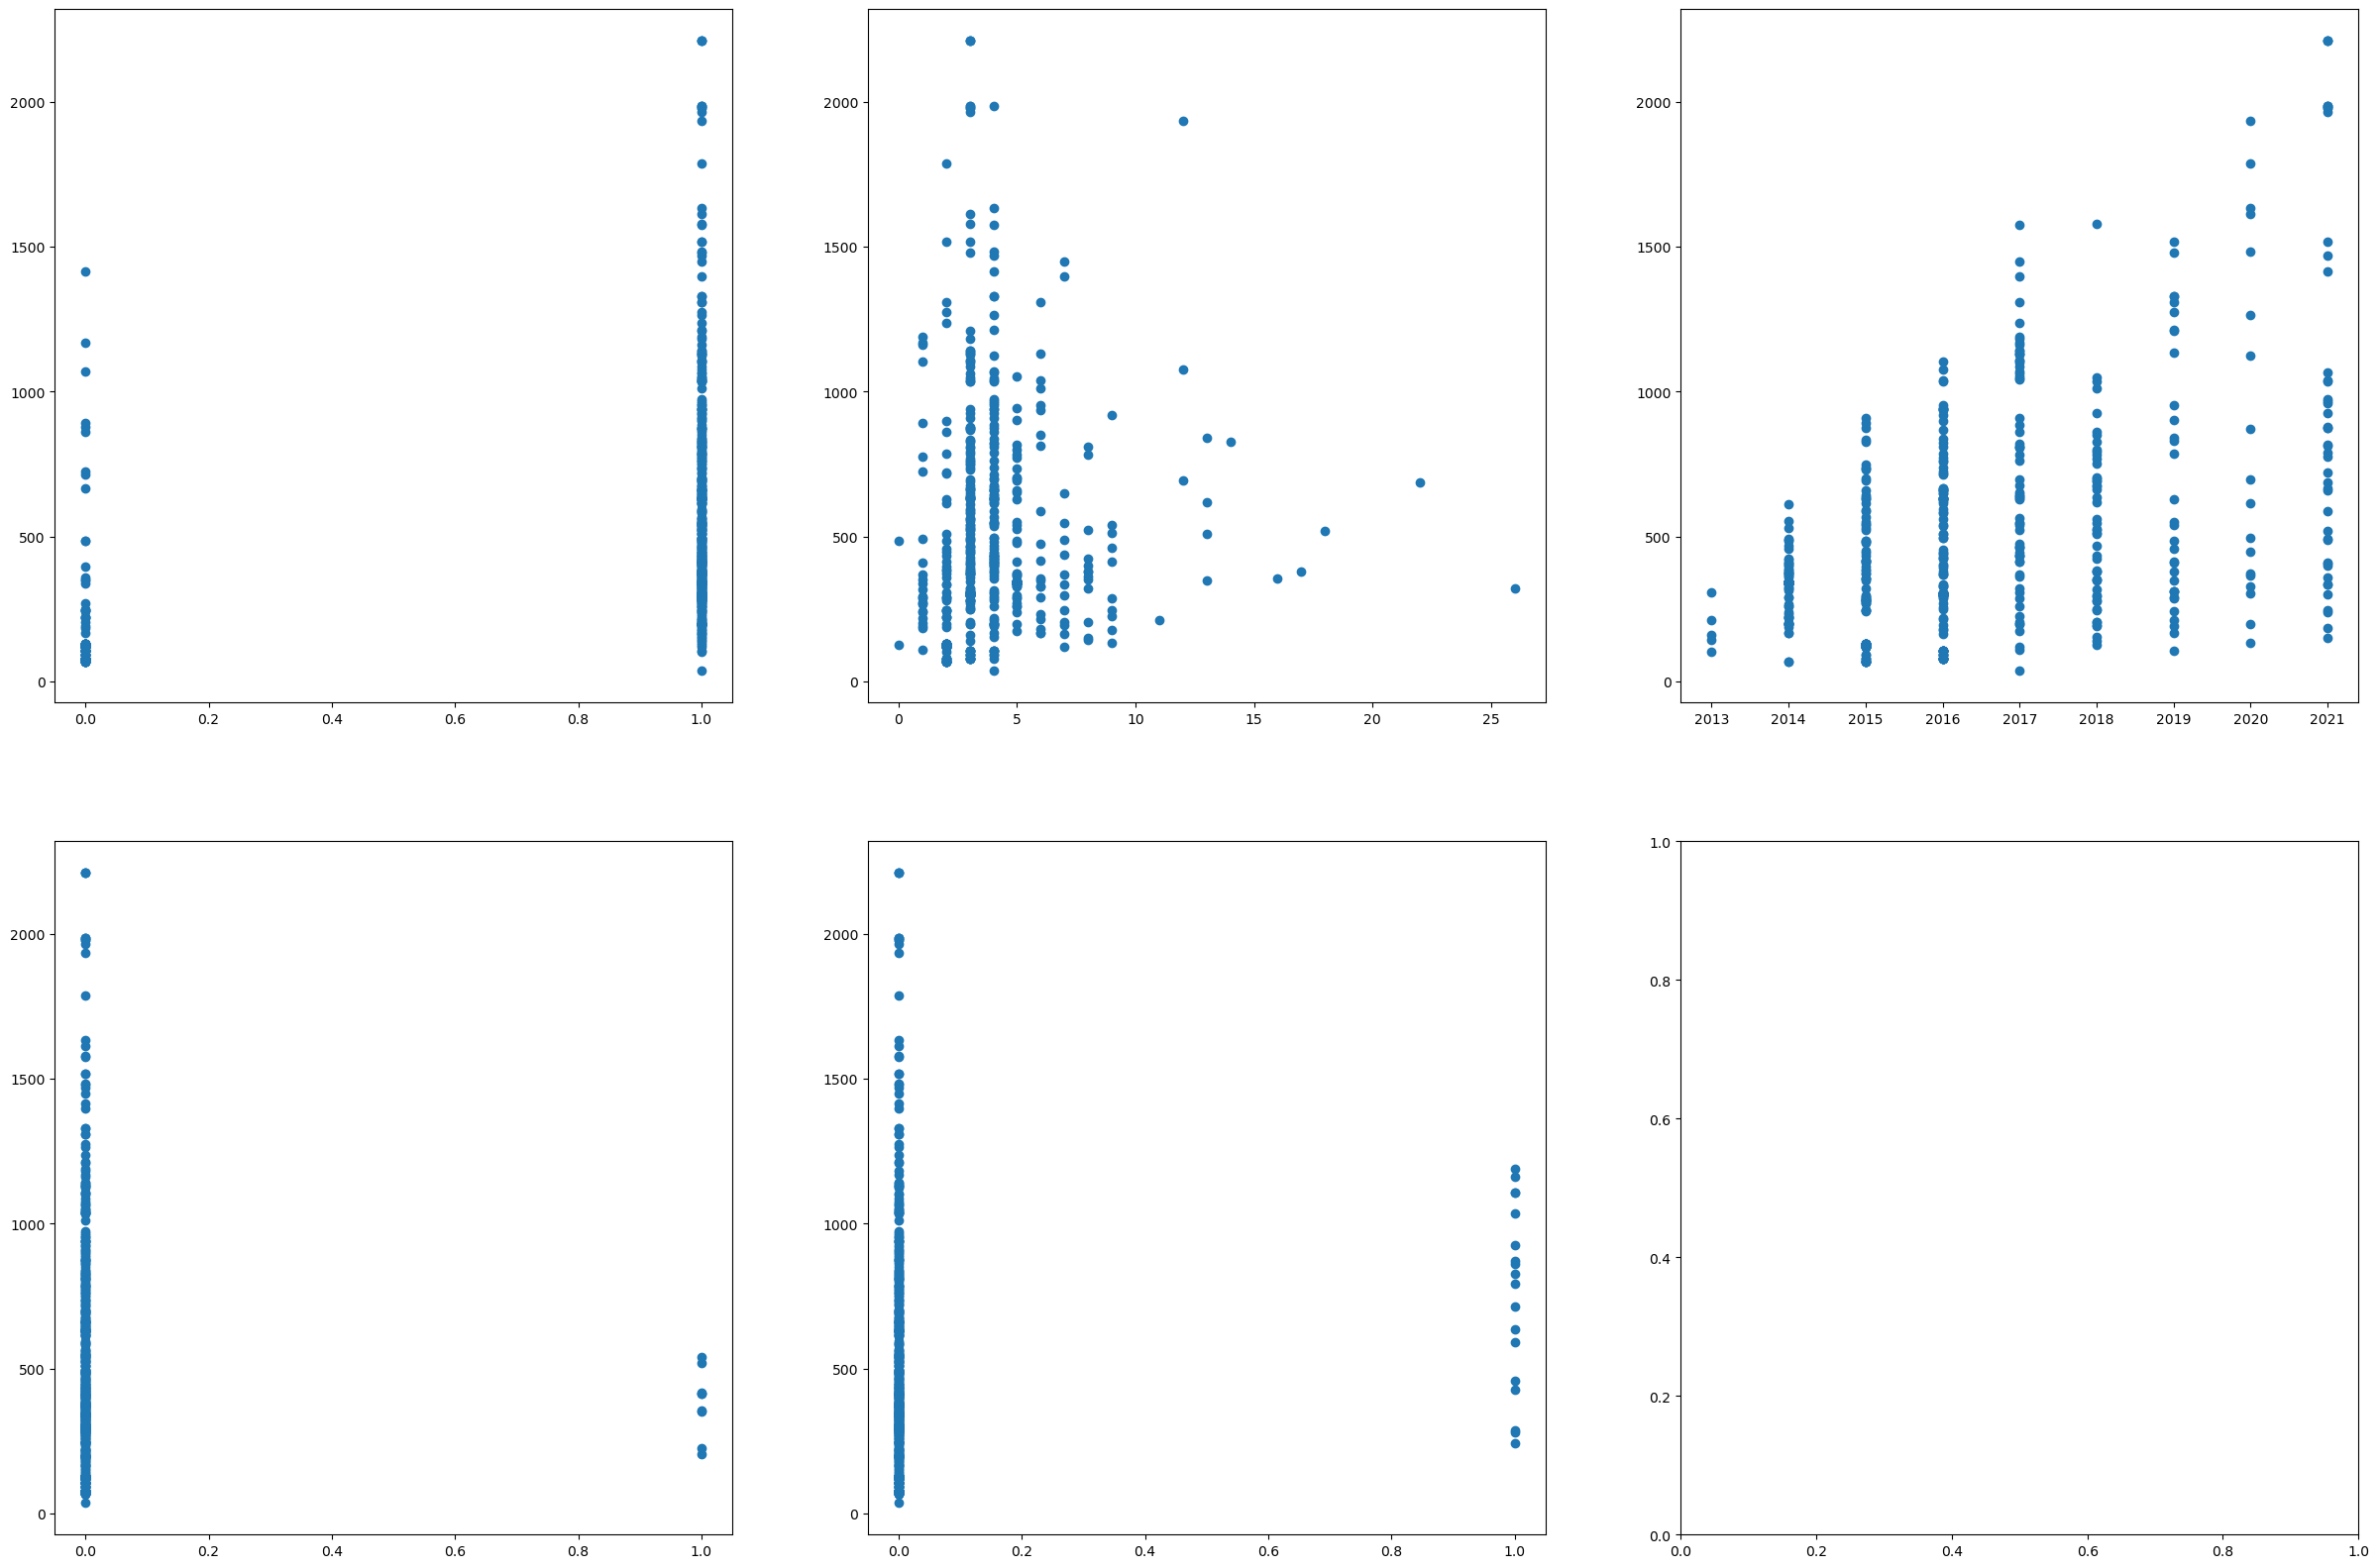

In [235]:
fig, ax = plt.subplots(2, 3, figsize = (30,20))
ax = ax.ravel()
for feature, i in zip(sel_features[4], range(6)):
    ax[i].scatter(data = Regression_Table_wDummies_no_outliers, x = feature, y = 'wait_time')

In [248]:
Regression_Table_no_outliers = Regression_Table.loc[outlierIndex].reset_index(drop = True)
Regression_Table_no_outliers.describe()

,wait_time,Number of Rooms,Property Area,Total Taxable Value,revised_cost,estimated_cost,proposed_units,number_of_proposed_stories,year,Median household income
count,656.000000,656.000000,656.000000,6.560000e+02,6.560000e+02,6.560000e+02,656.000000,656.000000,656.000000,656.000000
mean,491.734756,4.296029,2503.840346,2.419846e+06,1.186705e+07,1.130010e+07,46.400915,4.153963,2016.102134,102187.466463
std,361.947282,6.430573,5127.610274,5.124920e+06,1.707887e+07,1.650540e+07,62.512772,2.331153,2.102763,56625.117762
min,35.000000,0.000000,0.000000,0.000000e+00,1.000000e+03,1.000000e+00,0.000000,0.000000,2013.000000,250.000000
25%,303.000000,0.000000,817.000000,4.292945e+05,5.250000e+05,4.000000e+05,1.000000,3.000000,2014.000000,60104.000000
50%,340.000000,3.000000,1300.000000,7.485275e+05,1.325000e+06,1.000000e+06,2.000000,4.000000,2016.000000,77473.000000
75%,631.000000,6.000000,1741.821429,1.769018e+06,2.600000e+07,2.600000e+07,136.000000,5.000000,2017.000000,152928.500000
max,2212.000000,78.000000,40796.800000,4.334277e+07,1.302400e+08,1.302400e+08,256.000000,26.000000,2021.000000,241167.000000


<AxesSubplot:xlabel='wait_time', ylabel='Count'>

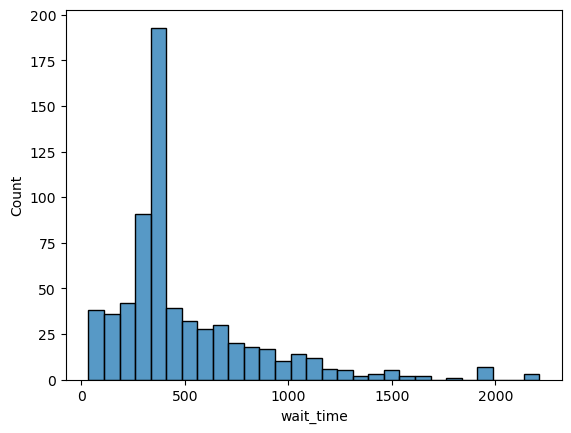

In [250]:
Regression_Table_no_outliers
sns.histplot(data = Regression_Table_no_outliers, x = 'wait_time')

In [285]:
X_no_dummy_no_outlier = Regression_Table_no_outliers.iloc[:,1:].values
y_no_dummy_no_outlier = Regression_Table_no_outliers['wait_time'].values
feature_names_2 = np.array(Regression_Table_no_outliers.iloc[:,1:].columns)

In [278]:
lasso_estimator_no_dummy_no_outliers = LassoCV().fit(X_no_dummy_no_outlier,y_no_dummy_no_outlier)

sel_features = []

for num in np.arange(1,10):
    lasso_selector = SequentialFeatureSelector(lasso_estimator_no_dummy_no_outliers, 
                                                       n_features_to_select=num, 
                                                       direction='forward').fit(X_no_dummy_no_outlier, 
                                                                                y_no_dummy_no_outlier)
    sel_features.append(lasso_selector.get_feature_names_out(feature_names_2))

sel_features

[array(['year'], dtype=object),
 array(['site_permit', 'year'], dtype=object),
 array(['site_permit', 'number_of_proposed_stories', 'year'], dtype=object),
 array(['num_rooms', 'site_permit', 'number_of_proposed_stories', 'year'],
       dtype=object),
 array(['num_rooms', 'property_area', 'site_permit',
        'number_of_proposed_stories', 'year'], dtype=object),
 array(['num_rooms', 'property_area', 'site_permit', 'proposed_units',
        'number_of_proposed_stories', 'year'], dtype=object)]

In [283]:
feature_dict = {'Median household income':'median_income', 'Number of Rooms': 'num_rooms',
                'Property Area': 'property_area', 'Total Taxable Value':'total_taxable_value'}

Regression_Table_no_outliers.rename(columns=feature_dict, inplace = True)

Regression_Table_no_outliers.columns

Index(['wait_time', 'num_rooms', 'property_area', 'total_taxable_value',
       'revised_cost', 'site_permit', 'estimated_cost', 'proposed_units',
       'number_of_proposed_stories', 'year', 'median_income'],
      dtype='object')

In [280]:
r2 = []
loglike = []

for num in np.arange(len(sel_features)):
    lm = smf.ols(formula = 'wait_time ~ '+ '+'.join(sel_features[num]), data = Regression_Table_no_outliers).fit()
    r2.append(lm.rsquared)
    loglike.append(lm.llf)

,R2,Log Likelyhood
0,0.262929,-4695.083120
1,0.327054,-4665.228801
2,0.334308,-4661.674044
3,0.338908,-4659.399366
4,0.344094,-4656.816610
5,0.349108,-4654.299599


In [281]:
pd.DataFrame({'Features':sel_features,'R2':r2, 'Log Likelyhood':loglike})

,Features,R2,Log Likelyhood
0,[year],0.262929,-4695.083120
1,"[site_permit, year]",0.327054,-4665.228801
2,"[site_permit, number_of_proposed_stories, year]",0.334308,-4661.674044
3,"[num_rooms, site_permit, number_of_proposed_st...",0.338908,-4659.399366
4,"[num_rooms, property_area, site_permit, number...",0.344094,-4656.816610
5,"[num_rooms, property_area, site_permit, propos...",0.349108,-4654.299599


In [286]:
lasso_estimator_no_dummy_no_outliers = LassoCV().fit(X_no_dummy_no_outlier,y_no_dummy_no_outlier)

sel_features = []
r2 = []
loglike = []

for num in np.arange(1,10):
    lasso_selector = SequentialFeatureSelector(lasso_estimator_no_dummy_no_outliers, 
                                                       n_features_to_select=num, 
                                                       direction='forward').fit(X_no_dummy_no_outlier, 
                                                                                y_no_dummy_no_outlier)
    sel_features.append(lasso_selector.get_feature_names_out(feature_names_2))

for num in np.arange(len(sel_features)):
    lm = smf.ols(formula = 'wait_time ~ '+ '+'.join(sel_features[num]), data = Regression_Table_no_outliers).fit()
    r2.append(lm.rsquared)
    loglike.append(lm.llf)    
    print(lm.summary())

pd.DataFrame({'Features':sel_features,'R2':r2, 'Log Likelyhood':loglike})

                            OLS Regression Results                            
Dep. Variable:              wait_time   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.262
Method:                 Least Squares   F-statistic:                     233.3
Date:                Tue, 07 Dec 2021   Prob (F-statistic):           2.87e-45
Time:                        23:23:28   Log-Likelihood:                -4695.1
No. Observations:                 656   AIC:                             9394.
Df Residuals:                     654   BIC:                             9403.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.775e+05   1.17e+04    -15.232      0.0

                            OLS Regression Results                            
Dep. Variable:              wait_time   R-squared:                       0.352
Model:                            OLS   Adj. R-squared:                  0.343
Method:                 Least Squares   F-statistic:                     43.84
Date:                Tue, 07 Dec 2021   Prob (F-statistic):           3.59e-56
Time:                        23:23:28   Log-Likelihood:                -4653.1
No. Observations:                 656   AIC:                             9324.
Df Residuals:                     647   BIC:                             9365.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

,Features,R2,Log Likelyhood
0,[year],0.262929,-4695.083120
1,"[site_permit, year]",0.327054,-4665.228801
2,"[site_permit, number_of_proposed_stories, year]",0.334308,-4661.674044
3,"[num_rooms, site_permit, number_of_proposed_st...",0.338908,-4659.399366
4,"[num_rooms, property_area, site_permit, number...",0.344094,-4656.816610
5,"[num_rooms, property_area, site_permit, propos...",0.349108,-4654.299599
6,"[num_rooms, property_area, site_permit, propos...",0.349849,-4653.925840
7,"[num_rooms, property_area, total_taxable_value...",0.351513,-4653.085191
8,"[num_rooms, property_area, total_taxable_value...",0.360534,-4648.490571
